# Supervised anomaly detection - Mel spectrogram

Although the dataset is only suitable for semi-supervised anomaly detection, we can practice **supervised anomaly detection** using the audio samples from the **test** set.

Firstly, we need to check whether we have enough audio samples in the test set. 

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create the CNN model
- **Kapre** to compute the mel spectrogram of the audio input in a Keras layer 
- **Matplotlib** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Reshape,
)

from kapre.composed import get_melspectrogram_layer


import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn 
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import datetime
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

Tensorflow datasets: 4.3.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Matplotlib: 3.4.2


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets: train (70%), validation (20%) and test (10%). 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["test[:70%]", "test[70%:90%]", "test[90%:]"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

We need to check whether we have enough data in every set and whether sets are balanced.

### Train

In [5]:
tfds.as_dataframe(train.take(3), info)

audio audio/id audio/machine  \
0  [-260, -286, -231, -99, -90, -16, 67, 73, -69,...  b'0079'         b'06'   
1  [-60, 46, 203, 49, 186, 246, -188, -3, 350, 71...  b'0074'         b'02'   
2  [239, 122, 152, 136, 203, 494, 710, 820, 818, ...  b'0005'         b'06'   

   audio/split  label  
0            1      1  
1            1      0  
2            1      0

Tensorflow internally represent strings as bytes, so we need to decode them to convert them into strings. We need to do it for each set.

In [6]:
train_df = tfds.as_dataframe(train, info)

# Convert byte-type texts to string-type texts
for col in train_df:
    if isinstance(train_df[col][0], bytes):
        train_df[col] = train_df[col].str.decode("utf8")

# Convert object-type columns to a more convenient data type
dct_types = {
    "audio/id": "string",
    "audio/machine": "string",
    "audio/split": "int",
    "label": "int"
}

train_df = train_df.astype(dct_types)
train_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[-260, -286, -231, -99, -90, -16, 67, 73, -69,...",0079,06,1,1
1,"[-60, 46, 203, 49, 186, 246, -188, -3, 350, 71...",0074,02,1,0
2,"[239, 122, 152, 136, 203, 494, 710, 820, 818, ...",0005,06,1,0
3,"[-204, 61, -165, -199, -510, -214, -39, 95, 21...",0011,00,1,0
4,"[-255, -52, -79, -20, 319, 309, 259, 406, 311,...",0015,06,1,0


Let's check whether the audio samples in the four machines are balanced using a pivot table.

In [7]:
(
    train_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
    .rename(columns={0: "Normal", 1: "Anomaly"})
)

label,Normal,Anomaly
audio/machine,,
00,74,96
02,62,83
04,74,70
06,72,68


We can consider that the test set is balanced enough.

### Validation set

In [8]:
tfds.as_dataframe(val.take(3), info)

audio audio/id audio/machine  \
0  [347, 109, 519, 743, 623, 282, 353, -120, 19, ...  b'0069'         b'04'   
1  [165, 165, -87, -580, -685, -633, -795, -927, ...  b'0096'         b'00'   
2  [-398, -646, -320, -167, -403, -599, -587, -27...  b'0020'         b'00'   

   audio/split  label  
0            1      0  
1            1      1  
2            1      1

In [9]:
val_df = tfds.as_dataframe(val, info)

# Convert byte-type texts to string-type texts
for col in val_df:
    if isinstance(val_df[col][0], bytes):
        val_df[col] = val_df[col].str.decode("utf8")

# Convert object-type columns to a more convenient data type
dct_types = {
    "audio/id": "string",
    "audio/machine": "string",
    "audio/split": "int",
    "label": "int"
}

val_df = val_df.astype(dct_types)
val_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[347, 109, 519, 743, 623, 282, 353, -120, 19, ...",0069,04,1,0
1,"[165, 165, -87, -580, -685, -633, -795, -927, ...",0096,00,1,1
2,"[-398, -646, -320, -167, -403, -599, -587, -27...",0020,00,1,1
3,"[-630, -659, -773, -560, -325, -321, -281, -28...",0119,00,1,1
4,"[121, 18, -89, 2, 364, 330, 177, -51, 167, 253...",0026,04,1,0


Let's check whether the audio samples in the four machines are balanced using a pivot table.

In [10]:
(
    val_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
    .rename(columns={0: "Normal", 1: "Anomaly"})
)

label,Normal,Anomaly
audio/machine,,
00,20,30
02,22,20
04,16,18
06,20,25


We can consider that the validation set is balanced enough.

### Test set

In [11]:
tfds.as_dataframe(test.take(3), info)

audio audio/id audio/machine  \
0  [-211, -351, -405, -402, -281, -62, -97, -290,...  b'0028'         b'02'   
1  [-95, 321, -35, -476, -336, -671, -427, -932, ...  b'0008'         b'02'   
2  [263, 190, 82, 69, -9, -197, 39, 21, -180, -50...  b'0081'         b'04'   

   audio/split  label  
0            1      1  
1            1      1  
2            1      1

In [12]:
test_df = tfds.as_dataframe(test, info)

# Convert byte-type texts to string-type texts
for col in test_df:
    if isinstance(test_df[col][0], bytes):
        test_df[col] = test_df[col].str.decode("utf8")

# Convert object-type columns to a more convenient data type
dct_types = {
    "audio/id": "string",
    "audio/machine": "string",
    "audio/split": "int",
    "label": "int"
}

test_df = test_df.astype(dct_types)
test_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[-211, -351, -405, -402, -281, -62, -97, -290,...",0028,02,1,1
1,"[-95, 321, -35, -476, -336, -671, -427, -932, ...",0008,02,1,1
2,"[263, 190, 82, 69, -9, -197, 39, 21, -180, -50...",0081,04,1,1
3,"[-407, -195, -28, -107, -352, -334, -318, -641...",0006,04,1,1
4,"[76, 17, 115, 542, 515, 228, 55, 131, 291, 429...",0058,00,1,1


Let's check whether the audio samples in the four machines are balanced using a pivot table.

In [13]:
(
    test_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
    .rename(columns={0: "Normal", 1: "Anomaly"})
)

label,Normal,Anomaly
audio/machine,,
00,6,17
02,16,8
04,10,12
06,8,9


We can consider that the test set is balanced enough.

## Supervised training

In [14]:
def get_info(item):
    return item["audio"], item["label"]

Let's prepare the sets for training. We get the audio numpy array and the label, and batch the sets.

In [15]:
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 64

train2 = train.map(get_info).batch(BATCH_SIZE).shuffle(SHUFFLE_BUFFER_SIZE)
val2 = val.map(get_info).batch(BATCH_SIZE)
test2 = test.map(get_info).batch(BATCH_SIZE)

For this model, we extract the mel spectrogram of the audio to feed a CNN. 

In [16]:
model = tf.keras.Sequential(
    [
        Reshape((160_000,1), input_shape=(160_000,)),
        get_melspectrogram_layer(
            input_shape=(info.features['audio'].shape[0], 1),
            n_fft=1024,
            win_length=1024,
            hop_length=512,
            n_mels=128,
            sample_rate=info.features['audio'].sample_rate,
        ),
        BatchNormalization(),
        Conv2D(filters=8, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(3, 2)),
        BatchNormalization(),
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(3, 2)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=64, activation="relu"),
        Dropout(rate=0.2),
        Dense(units=8, activation="relu"),
        Dropout(rate=0.2),
        Dense(units=1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 160000, 1)         0         
_________________________________________________________________
melspectrogram (Sequential)  (None, 311, 128, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 311, 128, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 311, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 103, 64, 8)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 103, 64, 8)        32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 103, 64, 16)       1

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Let's create a callback to plot the loss and accuracy per epoch in Tensorboard. 

In [18]:
log_dir = os.path.join("..", "logs", "supervised-mel", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

Let's create a callback to save the best model.

In [19]:
checkpoint_filepath = os.path.join("tmp", "supervised-mel", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(
    train2,
    epochs=25,
    shuffle=True,
    validation_data=val2,
    batch_size=32,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/25
38/38 [==============================] - 21s 529ms/step - loss: 0.8582 - accuracy: 0.5520 - val_loss: 0.6301 - val_accuracy: 0.5497
Epoch 2/25
38/38 [==============================] - 20s 518ms/step - loss: 0.5824 - accuracy: 0.6608 - val_loss: 0.6221 - val_accuracy: 0.5439
Epoch 3/25
38/38 [==============================] - 20s 521ms/step - loss: 0.5736 - accuracy: 0.6950 - val_loss: 0.5649 - val_accuracy: 0.6550
Epoch 4/25
38/38 [==============================] - 20s 522ms/step - loss: 0.4664 - accuracy: 0.7732 - val_loss: 0.6267 - val_accuracy: 0.5848
Epoch 5/25
38/38 [==============================] - 20s 525ms/step - loss: 0.4237 - accuracy: 0.8035 - val_loss: 0.5634 - val_accuracy: 0.6667
Epoch 6/25
38/38 [==============================] - 20s 517ms/step - loss: 0.4562 - accuracy: 0.7723 - val_loss: 0.5835 - val_accuracy: 0.6433
Epoch 7/25
38/38 [==============================] - 20s 519ms/step - loss: 0.3063 - accuracy: 0.8654 - val_loss: 0.8777 - val_accuracy: 0.5965

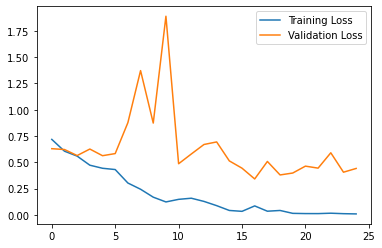

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

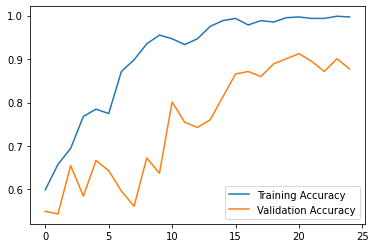

In [22]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

Plots shows big drops in accuracy and big surges in loss in the validation set. 

In [23]:
model.load_weights(checkpoint_filepath)

Let's check the accuracy in the test set.

In [24]:
test_loss, test_acc = model.evaluate(test2)
print(f"\nTest accuracy: {test_acc}")

6/6 [==============================] - 2s 325ms/step - loss: 1.1087 - accuracy: 0.8140

Test accuracy: 0.8139534592628479


Difference in accuracy between the validation and test set is ok.

Let's save the model to use it in the Streamlit app.

In [25]:
VERSION="4"
saved_model_path = model.save(os.path.join("..", "..", "..", "production", "backend", "models", "mel", VERSION), save_format='tf')

INFO:tensorflow:Assets written to: ../../../production/backend/models/mel/4/assets


INFO:tensorflow:Assets written to: ../../../production/backend/models/mel/4/assets


In [26]:
!saved_model_cli show --dir ../../../production/backend/models/mel/4 --all

2021-05-11 08:44:49.185623: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-05-11 08:44:49.185664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['reshape_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 160000)
        name: servi

## Metrics

In [27]:
pred = model.predict(test.batch(BATCH_SIZE))

In [28]:
test_df["prob"] = pred
test_df["label_pred"] = test_df["prob"] > 0.5
test_df = test_df.astype({"label_pred": "int"})
test_df.sample(5)

,audio,audio/id,audio/machine,audio/split,label,prob,label_pred
72,"[-212, -241, -177, -58, 20, -60, -204, -217, -...",0017,00,1,1,9.657045e-01,1
30,"[138, 195, 276, 398, 564, 527, 546, 416, 595, ...",0067,02,1,0,1.847148e-04,0
48,"[380, 415, 182, 194, 16, 12, 298, 613, 482, 41...",0086,02,1,0,7.327068e-07,0
13,"[31, -143, -26, -137, -3, 268, 472, 178, 153, ...",0067,04,1,0,6.010206e-11,0
25,"[-6, -29, -166, -159, -208, -160, -166, -229, ...",0104,00,1,1,1.341978e-05,0


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

### Machine_id=00

In [29]:
machine_id = "00"
temp = (
    test_df
    .query("`audio/machine` == @machine_id")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.65      0.79        17

    accuracy                           0.74        23
   macro avg       0.75      0.82      0.73        23
weighted avg       0.87      0.74      0.75        23



In [30]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[ 6  0]
 [ 6 11]]


In [31]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.8235


### Machine_id=02

In [32]:
machine_id = "02"
temp = (
    test_df
    .query("`audio/machine` == @machine_id")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.80      1.00      0.89         8

    accuracy                           0.92        24
   macro avg       0.90      0.94      0.91        24
weighted avg       0.93      0.92      0.92        24



In [33]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[14  2]
 [ 0  8]]


In [34]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.9375


### Machine_id=04

In [35]:
machine_id = "04"
temp = (
    test_df
    .query("`audio/machine` == @machine_id")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.67      0.80        12

    accuracy                           0.82        22
   macro avg       0.86      0.83      0.82        22
weighted avg       0.87      0.82      0.82        22



In [36]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[10  0]
 [ 4  8]]


In [37]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.8333


### Machine_id=06

In [38]:
machine_id = "06"
temp = (
    test_df
    .query("`audio/machine` == @machine_id")
)
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.86      0.67      0.75         9

    accuracy                           0.76        17
   macro avg       0.78      0.77      0.76        17
weighted avg       0.78      0.76      0.76        17



In [39]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[7 1]
 [3 6]]


In [40]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.7708


## Conclusions

- Metrics among machines are not consistent, so feeding the machine id to the model could help to improve performance. 
- This CNN model using spectrogram is harder to train than this CNN model using mel-spectrogram and provides worse metrics.
- The gaps in accuracy between the train set and validation set and the validation set and the test set are ok
- To improve its performance, this models needs more data.
